# **Checking for GPU**

In [1]:
!nvidia-smi

Wed May 17 23:09:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

# Confirm that the GPU is detected
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


**Installing dependencies**

In [3]:
!pip install transformers klib sentencepiece
# klib -> A Python library for importing, cleaning, analyzing and preprocessing data.
# transformers -> Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models.
# sentencepiece -> MT5Tokenizer requires the SentencePiece library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.7 MB/s eta 0:00:00


In [4]:
# imports

from transformers import (
    MT5Config, 
    TFMT5ForConditionalGeneration,
    MT5Model, 
    MT5Tokenizer, 
    AdamW,
    AutoConfig
)
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import klib
import matplotlib.pyplot as plt
import numpy as np
import os


In [5]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/685 Project/NLP Ethos - ethos.csv')
print('Shape of the Dataframe: ', df.shape)
display(df.head())
display(df.columns)

english_df = df[df['Language'] == 'English']
hindi_df = df[df['Language'] == 'Hindi']


Shape of the Dataframe:  (1022, 4)


,Language,Text,Label,Translation
0,Hindi,You should know women's sports are a joke,1,आपको पता होना चाहिए कि महिला खेल एक मजाक होता है।
1,Hindi,You look like Sloth with deeper Down’s syndrome,1,आप गहरे डाउन सिंड्रोम वाले स्लॉथ की तरह दिखते हैं
2,Hindi,You look like Russian and speak like Indian. B...,1,आप रूसी की तरह दिखते हैं और भारतीय की तरह बोलत...
3,Hindi,"Women deserve to be abused, I guess.",1,मुझे लगता है कि महिलाएं दुर्व्यवहार के लायक हैं।
4,Hindi,Women are made for making babies and cooking d...,1,औरतें बच्चे पैदा करने और रात का खाना बनाने के ...


Index(['Language', 'Text', 'Label', 'Translation'], dtype='object')

**Downloading Tokenizer**

In [7]:
model_path = '/content/gdrive/MyDrive/685 Project/fine-tuned_mt5/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

In [8]:
# Loading tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MT5Tokenizer

tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [9]:
len(tokenizer.vocab)

250100

**Tokenizing**

In [10]:
# Adding the prefix  as a special token
LANG_TOKEN_MAPPING = {
    'detect hate speech': '<detect_hs>'
}
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)

print(tokenizer.all_special_tokens)

['</s>', '<unk>', '<pad>', '<detect_hs>']


In [11]:
MAX_LEN = 512 # Use the maximum input length for MT5 or ByT5
MAX_LABEL_LEN = 3
TASK_PREFIX = "<detect_hs> "

# Placeholders input
e_input_ids, e_input_masks, h_input_ids, h_input_masks = [], [], [], []

# Placeholders output
e_output_ids, e_output_masks, h_output_ids, h_output_masks = [], [], [], []

# 
e_hate, e_non_hate, h_hate, h_non_hate = 0, 0, 0, 0

for index, row in df.iterrows():
  sentence = row.Translation
  label = row.Label

  input_encoded = tokenizer.encode_plus(
      TASK_PREFIX + sentence + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  label_ = "hate" if label else "neutral"
  output_encoded = tokenizer.encode_plus(
      label_ + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LABEL_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  labels = output_encoded['input_ids']
  labels[labels == tokenizer.pad_token_id] = -100

  if row.Language == 'Hindi':
    if label: h_hate += 1
    else: h_non_hate += 1
    h_input_ids.append(input_encoded['input_ids'])
    h_input_masks.append(input_encoded['attention_mask'])
    h_output_ids.append(labels)
    h_output_masks.append(output_encoded['attention_mask'])

  elif row.Language == 'English':
    if label: e_hate += 1
    else: e_non_hate += 1
    e_input_ids.append(input_encoded['input_ids'])
    e_input_masks.append(input_encoded['attention_mask'])
    e_output_ids.append(labels)
    e_output_masks.append(output_encoded['attention_mask'])



# Convert the lists into tensors.
e_input_ids = torch.cat(e_input_ids, dim=0)
e_input_masks = torch.cat(e_input_masks, dim=0)
e_output_ids = torch.cat(e_output_ids, dim=0)
e_output_masks = torch.cat(e_output_masks, dim=0)

h_input_ids = torch.cat(h_input_ids, dim=0)
h_input_masks = torch.cat(h_input_masks, dim=0)
h_output_ids = torch.cat(h_output_ids, dim=0)
h_output_masks = torch.cat(h_output_masks, dim=0)

from torch.utils.data import TensorDataset, random_split

e_dataset = TensorDataset(e_input_ids, e_output_ids, e_input_masks, e_output_masks)
h_dataset = TensorDataset(h_input_ids, h_output_ids, h_input_masks, h_output_masks)

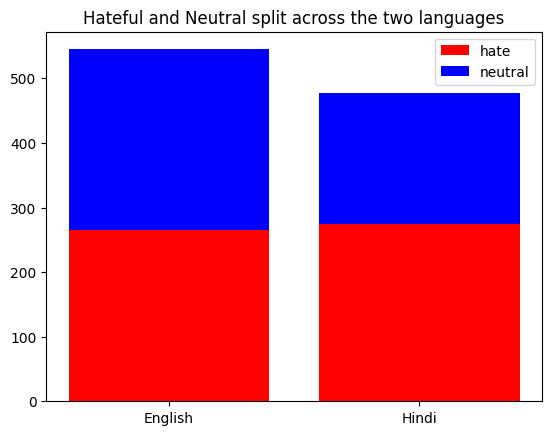

In [12]:
# EDA

import matplotlib.pyplot as plt
import numpy as np
 

lang = ['English', 'Hindi']
hate = np.array([english_df[english_df['Label']==1].shape[0], hindi_df[hindi_df['Label']==1].shape[0]])
neutral = np.array([english_df[english_df['Label']==0].shape[0], hindi_df[hindi_df['Label']==0].shape[0]])
 

plt.bar(lang, hate, color='r')
plt.bar(lang, neutral, bottom=hate, color='b')

plt.legend(["hate", "neutral"])
plt.title("Hateful and Neutral split across the two languages")
plt.show()

**Train-test split**

In [13]:
# Create a 80-20 train-validation split.
train_size = int(0.8 * len(h_dataset))
val_size = len(h_dataset) - train_size

# Randomly selecting samples.
h_train_dataset, val_dataset = random_split(h_dataset, [train_size, val_size])
print(len(val_dataset))

96


**DataLoaders**

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


# Create the DataLoaders for our training and validation sets.

batch_size = 4

# RandomSampler for training
e_train_dataloader = DataLoader(
            e_dataset,
            sampler = RandomSampler(e_dataset),
            batch_size = batch_size
        )

h_train_dataloader = DataLoader(
            h_train_dataset,
            sampler = RandomSampler(h_train_dataset),
            batch_size = batch_size
        )

# SequentialSampler for validation
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )



**Download Model**

In [15]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

model.cuda() # Tell PyTorch to run this model on the GPU

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

**Optimizer**

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)

**Model Training**

English

In [17]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(e_train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

import random
import numpy as np
from time import time, sleep

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(e_train_dataloader):

        b_input_ids = batch[0].to(device)
        b_output_ids = batch[1].to(device)
        b_input_masks = batch[2].to(device)
        b_output_masks = batch[3].to(device)
        
        model.zero_grad()

        outputs = model(input_ids=b_input_ids, 
                        labels=b_output_ids, 
                        attention_mask=b_input_masks, 
                        decoder_attention_mask=b_output_masks)

        loss = outputs.loss
        logits = outputs.logits
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(e_train_dataloader)            
    print(avg_train_loss)



======== Epoch 1 / 10 ========
Training...
18.58448194935374

======== Epoch 2 / 10 ========
Training...
9.784819192259851

======== Epoch 3 / 10 ========
Training...
4.4695244231363285

======== Epoch 4 / 10 ========
Training...
1.5634193394305933

======== Epoch 5 / 10 ========
Training...
0.7312145457487472

======== Epoch 6 / 10 ========
Training...
0.4820965997548434

======== Epoch 7 / 10 ========
Training...
0.5557561818048031

======== Epoch 8 / 10 ========
Training...
0.5026122834125575

======== Epoch 9 / 10 ========
Training...
0.43332522591222483

======== Epoch 10 / 10 ========
Training...
0.46002034418774346


Hindi

In [18]:

epochs = 5

total_steps = len(h_train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

import random
import numpy as np
from time import time, sleep

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(h_train_dataloader):

        b_input_ids = batch[0].to(device)
        b_output_ids = batch[1].to(device)
        b_input_masks = batch[2].to(device)
        b_output_masks = batch[3].to(device)
        
        model.zero_grad()

        outputs = model(input_ids=b_input_ids, 
                        labels=b_output_ids, 
                        attention_mask=b_input_masks, 
                        decoder_attention_mask=b_output_masks)

        loss = outputs.loss
        logits = outputs.logits
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(h_train_dataloader)            
    print(avg_train_loss)



======== Epoch 1 / 5 ========
Training...
0.4026395839561398

======== Epoch 2 / 5 ========
Training...
0.38309824257157743

======== Epoch 3 / 5 ========
Training...
0.3410143210979489

======== Epoch 4 / 5 ========
Training...
0.3418065871616515

======== Epoch 5 / 5 ========
Training...
0.387611342400002


**Save the model**

In [19]:
torch.save(model.state_dict(), model_path+f"english_followed_by_hindi.pt")

**Validation**

In [20]:
# validation
model.eval()

v_match = 0

for step, batch in enumerate(validation_dataloader):
    
    v_input_ids = batch[0].to(device)
    v_output_ids = batch[1].to(device)
    v_input_masks = batch[2].to(device)
    v_output_masks = batch[3].to(device)
  
    v_outputs = model.generate(input_ids=v_input_ids, 
                            attention_mask=v_input_masks,
                            max_length=3)
    
    for v_input_id, true_v_output, pred_v_output in zip(v_input_ids, v_output_ids, v_outputs):
      true_label = tokenizer.decode(true_v_output, skip_special_tokens=True)
      pred_label = tokenizer.decode(pred_v_output, skip_special_tokens=True)
      if pred_label == true_label:
        v_match += 1
      else:
        print()
        print(f"{tokenizer.decode(v_input_id, skip_special_tokens=True)} true={true_label} pred={pred_label}")
      
v_acc = v_match/len(val_dataset)

print(f"\nval acc = {v_acc}\n")


बधाई हो। आपने समझ लिया कि आप एक मूर्ख हैं और अब और नहीं होना चाहते। आप एक वास्तव में हीरो हैं।  true=hate  pred=neutral 

सभी एशियाई लोग इस एक व्यक्ति के समान लगते हैं। वह एशिया की मां है।  true=neutral  pred=hate 

अगर मुझे डाउन सिंड्रोम होता तो मैं अपनी जान दे देता  true=hate  pred=neutral 

लोग अपने लिंग को बदलते जा रहे हैं और मैं एक टैटू का निर्णय नहीं ले सकता।  true=hate  pred=neutral 

यह सही नहीं है, सऊदी अरब में महिलाओं को स्वतंत्रता की अपूर्णता है।  true=neutral  pred=hate 

क्या यह आदमी वास्तव में ऑटिस्टिक है या वह इसे ढोंग कर रहा है  true=neutral  pred=hate 

चिंता एक मानव मेम की परिभाषा है। चिंता विकार एक बहाना है। ऐसी कोई बात नहीं।  true=hate  pred=neutral 

नमस्ते, मैं टेक सपोर्ट से बात कर रहा हूँ।  true=hate  pred=neutral 

मुझे मानसिक रूप से विकलांग लोगों से नफरत है जो मेरे बच्चों को छूने की कोशिश कर रहे हैं।  true=hate  pred=neutral 

"ABU DA BI ABA DU BA BA HAMUD! देखो? मैं भी अरब पुरोहित हूँ। यह वे ध्वनि कैसी होती है। सही है ना? वे मजाक हैं।"  true=hate  pred=neutra

**Testing**

In [25]:
test_df = pd.read_csv("/content/gdrive/MyDrive/685 Project/Friends - hindi - Sheet1.csv")
print('Shape of the Dataframe: ', test_df.shape)
display(test_df.head())

test_input_ids, test_input_masks, test_output_ids, test_output_masks = [], [], [], []

for index, row in test_df.iterrows():
  sentence = row.Translations
  label = row.label

  input_encoded = tokenizer.encode_plus(
      TASK_PREFIX + sentence + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  label_ = "hate" if label else "neutral"
  output_encoded = tokenizer.encode_plus(
      label_ + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LABEL_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  labels = output_encoded['input_ids']
  labels[labels == tokenizer.pad_token_id] = -100

  test_input_ids.append(input_encoded['input_ids'])
  test_input_masks.append(input_encoded['attention_mask'])
  test_output_ids.append(labels)
  test_output_masks.append(output_encoded['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_input_masks = torch.cat(test_input_masks, dim=0)
test_output_ids = torch.cat(test_output_ids, dim=0)
test_output_masks = torch.cat(test_output_masks, dim=0)

test_dataset = TensorDataset(test_input_ids, test_output_ids, test_input_masks, test_output_masks)
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = 1
        )


t_match = 0

for step, batch in enumerate(test_dataloader):
    
    t_input_ids = batch[0].to(device)
    t_output_ids = batch[1].to(device)
    t_input_masks = batch[2].to(device)
    t_output_masks = batch[3].to(device)
  
    t_outputs = model.generate(input_ids=t_input_ids, 
                            attention_mask=t_input_masks,
                            max_length=3)
    
    for t_input_id, true_t_output, pred_t_output in zip(t_input_ids, t_output_ids, t_outputs):
      true_label = tokenizer.decode(true_t_output, skip_special_tokens=True)
      pred_label = tokenizer.decode(pred_t_output, skip_special_tokens=True)
      if pred_label == true_label:
        t_match += 1
      else:
        print()
        print(f"{tokenizer.decode(t_input_id, skip_special_tokens=True)} true={true_label} pred={pred_label}")
      
t_acc = t_match/len(test_dataset)

print(f"\ntest acc = {t_acc}\n")

Shape of the Dataframe:  (61, 3)


,Text,label,Translations
0,"Nevermind, my girlfriend’s a lesbian.",1,"कोई बात नहीं, मेरी गर्लफ्रेंड लेस्बियन है।"
1,Yuck! Are you gay?,1,छी! क्या आप समलैंगिक हैं?
2,"Hey, Joey. Are men ever nice to strange women ...",1,"हे, जोए। क्या पुरुष कभी किसी अजनबी महिला के प्..."
3,"Wanted:Female Roommate. Non-smoker, non-ugly.",1,"चाहिए: महिला रूममेट. धूम्रपान नहीं, बिना बदसूर..."
4,You kissed a guy! Oh my god. Be a man!,1,तुमने एक आदमी को चुम्मा दिया! हे भगवान। एक आदम...



कोई बात नहीं, मेरी गर्लफ्रेंड लेस्बियन है।  true=hate  pred=neutral 

छी! क्या आप समलैंगिक हैं?  true=hate  pred=neutral 

हे, जोए। क्या पुरुष कभी किसी अजनबी महिला के प्रति बिना किसी कारण के अच्छे व्यवहार करते हैं?  true=hate  pred=neutral 

जैसा चाहो, यार। तुमने एक आदमी को चुम्मा दिया! मेरे लिए तुम मौजूद नहीं हो।  true=hate  pred=neutral 

तुम्हारे कोई मानक नहीं हैं। तुम वह व्यक्ति हो जो पचास मिनट के भीतर तलाक होने के बाद एक आदमी के पीछे जाता है।  true=hate  pred=neutral 

मुझे एक योजना चाहिए थी, अपने पुरुष से पार करने के लिए। और पुरुष का विपरीत क्या होता है? जाम।  true=hate  pred=neutral 

चैंडलर, तुम घिनौने हो। कौन शार्क पॉर्न देखता है!  true=hate  pred=neutral 

असली दुनिया में आपका स्वागत है! यह बहुत बेकार है।  true=hate  pred=neutral 

मैं एक औरतों के दीवाने नहीं हूँ। मैं किसी एक औरत का नाम भी उठा नहीं सकता, जिससे मैंने सच्चा कारण बताकर ब्रेकअप किया हो।  true=hate  pred=neutral 

जैसा कि आप सभी जानते हैं, मैं एक शांतिवादी हूँ जिसका अर्थ है कि मुझे युद्ध की कोई इच्छा नहीं है - कि